In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/dram-test/test/test/post_impressionism/henri-de-toulouse-lautrec'):
    break
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00a 0:00:01


In [3]:
import zipfile
import glob
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random


from sklearn.model_selection import train_test_split
from sklearn import metrics
import torch
from torchvision import datasets,models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torchvision.transforms import ColorJitter
from transformers import SegformerImageProcessor
import evaluate
from torch import nn
import torch.nn.functional as F
import wandb
import scipy
from tqdm.auto import tqdm



np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

2024-07-28 16:07:17.134194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 16:07:17.134397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 16:07:17.287217: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
id2label = {
            0: 'background',
            1: 'bird',
            2: 'boat',
            3: 'bottle',
            4: 'cat',
            5: 'chair',
            6: 'cow',
            7: 'dog',
            8: 'horse',
            9: 'person',
            10: 'pottedplant',
            11: 'sheep',
}

label2id = {v: k for k, v in id2label.items()}
model_checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"

In [5]:
file_prefix = '/kaggle/input/dram-test/labels/labels'
filename = '/kaggle/input/dram-test/test/test/dram_with_unseen.txt'
test_list = []
with open(filename) as file:
    for line in file:
        test_list.append(os.path.join(file_prefix, line.rstrip()) + '.png')
print(test_list[:5])

['/kaggle/input/dram-test/labels/labels/realism/albert-anker/die-bauern-und-die-zeitung-1867.png', '/kaggle/input/dram-test/labels/labels/realism/albert-anker/display-image.png', '/kaggle/input/dram-test/labels/labels/realism/albert-anker/grandmother.png', '/kaggle/input/dram-test/labels/labels/realism/albert-anker/hohes-alter-ii-alte-frau-sich-aufw-rmend-1885.png', '/kaggle/input/dram-test/labels/labels/realism/albert-anker/jeune-fille-nourrissant-les-poules-1865.png']


In [9]:
class PaintingSegDataset(Dataset):
    def __init__(self, file_list, transform=None,use_gpu=torch.cuda.is_available()): #df(1st)
        self.file_list = file_list
        self.transform = transform
        self.filelength = len(file_list)
        self.use_gpu = use_gpu
        self.id_to_trainid = {
            0: 0,
            3: 1,
            4: 2,
            5: 3,
            8: 4,
            9: 5,
            10: 6,
            12: 7,
            13: 8,
            15: 9,
            16: 10,
            17: 11,
        }
        self.debug = True


    def __len__(self):
        return self.filelength

    def __getitem__(self, idx):
        label_path = self.file_list[idx]
        
        img_path = label_path[:-4] + '.jpg'
        img_path = img_path.replace("labels", "test")
        img_orig = Image.open(img_path).convert('RGB')
        
        if label_path[-3:] == 'png':
            label = np.array(Image.open(label_path), dtype=np.float32)
       
        label_copy = 255 * np.ones(label.shape, dtype=np.int8)
        for k, v in self.id_to_trainid.items():
            label_copy[label == k] = v
            
        label = Image.fromarray(label_copy)
        
        #label = label.convert('L')
        #transform = v2.Compose([v2.Resize((512,512))])
        #img_orig = transform(img_orig)
        #print(tensor.unique())  
        #img = self.jitter(img)
        
        inputs = self.transform(images=img_orig, segmentation_maps=label, return_tensors="pt", do_reduce_labels=False)
        #print(inputs)
        
        img = inputs["pixel_values"].squeeze()  # Remove batch dimension
        label = inputs["labels"].squeeze()
        
        #print(img.shape)
        #print(label.shape)
        
        if self.use_gpu:
            img = img.cuda()
            label = label.cuda()
       
        return img, label
    
class PaintingSegDataset1(PaintingSegDataset):
    def __getitem__(self, idx):
        label_path = self.file_list[idx]
        
        img_path = label_path[:-4] + '.jpg'
        img_path = img_path.replace("labels", "test")
        #print(img_path)
        img_orig = Image.open(img_path).convert('RGB')
        
        if label_path[-3:] == 'png':
            label = np.array(Image.open(label_path), dtype=np.float32)
       
        label_copy = 255 * np.ones(label.shape, dtype=np.int8)
        for k, v in self.id_to_trainid.items():
            label_copy[label == k] = v
            
        label = Image.fromarray(label_copy)
        
        #label = label.convert('L')
        transform = v2.Compose([v2.Resize((512,512))])
        img_orig = transform(img_orig)
        #print(tensor.unique())  
        #img = self.jitter(img)
        
        inputs = self.transform(images=img_orig, segmentation_maps=label, return_tensors="pt", do_reduce_labels=False)
        #print(inputs)
        
        img = inputs["pixel_values"].squeeze()  # Remove batch dimension
        label = inputs["labels"].squeeze()
        
        #print(img.shape)
        #print(label.shape)
        
        if self.use_gpu:
            img = img.cuda()
            label = label.cuda()
       
        return img, label, img_orig


In [10]:
image_processor = SegformerImageProcessor.from_pretrained(model_checkpoint)

test_dataset = PaintingSegDataset(test_list,transform=image_processor)

test_dataset1 = PaintingSegDataset1(test_list,transform=image_processor)


In [11]:
test_dataset[1][1].unique()

tensor([0, 3])

(512, 512, 3)
(512, 512, 3)
[  0 128 192]


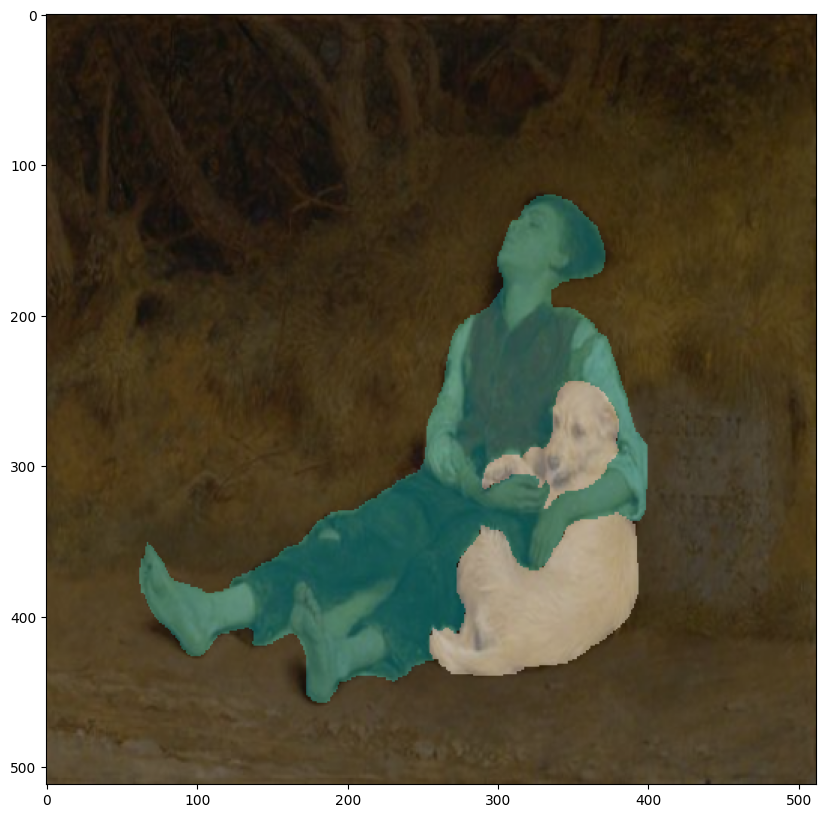

In [20]:

def color_palette():
    """Color palette that maps each class to RGB testues.
    
    This one is actually taken from ADE20k.
    """
    return [[255, 0, 0],    # Red
    [0, 255, 0],    # Green
    [0, 0, 255],    # Blue
    [255, 255, 0],  # Yellow
    [0, 255, 255],  # Cyan
    [255, 0, 255],  # Magenta
    [192, 192, 192],# Silver
    [128, 0, 0],    # Maroon
    [128, 128, 0],  # Olive
    [0, 128, 128],  # Teal
    [0, 0, 128],    # Navy
    [255, 165, 0] ]

def vizualize_label(segmentation_map,image=0,label_only=False):

    palette = color_palette()

    color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    segmentation_map = segmentation_map
    for label, color in enumerate(palette):
        color_segmentation_map[segmentation_map - 1 == label, :] = color
    #print(ground_truth_color_seg.shape)
    # Convert to BGR
    ground_truth_color_seg = color_segmentation_map[..., ::-1]
    img = np.array(image)
    print(img.shape)
    #img = np.transpose(img)
    print(img.shape)
    print(np.unique(ground_truth_color_seg))
    if image == 0 or label_only:
        img = ground_truth_color_seg * 0.5 
    else:
        img = ground_truth_color_seg * 0.5 + img * 0.5

    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()
    
v_index = 10
segmentation_map = test_dataset1[v_index][1]
image = test_dataset1[v_index][2]
vizualize_label(segmentation_map,image)


In [13]:
batch_size = 32
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
from transformers import SegformerForSemanticSegmentation
import requests

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=12,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

weight_file_name = 'SegFormerSegFormer-full-cont-jitter1'


if not torch.cuda.is_available():
    print()
    model.load_state_dict(torch.load('/kaggle/input/segformer-weights/pytorch/default/5/' + weight_file_name + '.pth',map_location=torch.device('cpu')))

else:
    print('using gpu')
    model.load_state_dict(torch.load('/kaggle/input/segformer-weights/pytorch/default/5/' + weight_file_name + '.pth',map_location=torch.device('cuda')) )

#model.config
print(model.state_dict()['decode_head.linear_c.0.proj.weight'].device)


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([12]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([12, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



cpu


In [15]:
# save results, vizualize prediction
model.eval()

metric = evaluate.load("mean_iou")

def compute_metrics(logits,labels,per_category=False):
  with torch.no_grad():
    #logits, labels = eval_pred
    #logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=12,
            ignore_index=255,
            reduce_labels=False,
        )
    print(metrics)
    if per_category:
        # add per category metrics as individual key-testue pairs
        per_category_miou = metrics.pop("per_category_miou").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"miou_{id2label[i]}": v for i, v in enumerate(per_category_miou)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
    
    return metrics,pred_labels

progress_bar_test = tqdm(range(len(test_loader)))

test_miou_avg = 0


vizualization_pred_label = torch.tensor(0)
pred_labels_list = []
miou_sums = {}
miou_sums['mean_iou'] = 0
miou_sums['per_category_iou'] = np.zeros(12)
label_occurences = np.zeros(12)

cnt = 0

for test_features_batch, test_labels_batch in test_loader:
    with torch.no_grad():       

        outputs = model(test_features_batch, test_labels_batch)
   
        metrics,pred_labels = compute_metrics(outputs['logits'], test_labels_batch)

        test_miou_avg += metrics['mean_iou']
        print(metrics['mean_iou'])
        #print(metrics)
        per_category_iou_batch = np.array(metrics['per_category_iou'])
        label_occurences += np.ones(12) - np.isnan(per_category_iou_batch)  
        # if iou of a category is NaN, this means that the union of this label was 0 for the whole batch
        # thus the label did not appear in the batch and is excluded from analysis for that label
        per_category_iou_batch = np.nan_to_num(per_category_iou_batch)

        for key, value in metrics.items():
            if "iou" in key:
                if key == 'mean_iou':
                    miou_sums['mean_iou'] += value
                elif key == 'per_category_iou': # "per category iou"
                    miou_sums['per_category_iou'] += per_category_iou_batch
                    
        #print(pred_labels)
        pred_labels_list.append(pred_labels)

        progress_bar_test.update(1)
    #cnt += 1
    #if cnt == 3:
    #   break
    
print(vizualization_pred_label.shape)

print(miou_sums)
miou_sums['mean_iou'] = miou_sums['mean_iou'] /len(test_loader)
miou_sums['per_category_iou'] = miou_sums['per_category_iou'] / label_occurences
print(miou_sums)


  0%|          | 0/23 [00:00<?, ?it/s]

{'mean_iou': 0.2794236607945208, 'mean_accuracy': 0.3997558026938724, 'overall_accuracy': 0.8532187781084506, 'per_category_iou': array([0.90771108, 0.10816464, 0.58253838, 0.59633172, 0.        ,
       0.05165323, 0.15309087, 0.28867437, 0.06193345, 0.58246927,
       0.        , 0.0205169 ]), 'per_category_accuracy': array([0.97121182, 0.14940951, 0.88588928, 0.83473719, 0.        ,
       0.05546723, 0.16258549, 0.51422282, 0.53500451, 0.66708463,
       0.        , 0.02145715])}
0.2794236607945208
{'mean_iou': 0.2148771236010163, 'mean_accuracy': 0.2944029471598107, 'overall_accuracy': 0.7855981588363647, 'per_category_iou': array([0.8245951 , 0.01560543, 0.56161645, 0.02008371, 0.        ,
       0.15130866, 0.04539251, 0.10106546, 0.20443479, 0.59922349,
       0.05519988, 0.        ]), 'per_category_accuracy': array([0.96215875, 0.01625801, 0.70240002, 0.02139979, 0.        ,
       0.17592297, 0.0466637 , 0.11278229, 0.65251511, 0.78753485,
       0.05519988, 0.        ])}
0.2

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'mean_iou': 0.21693627020228268, 'mean_accuracy': 0.39412847331208983, 'overall_accuracy': 0.8319426774978638, 'per_category_iou': array([0.88896088, 0.06844398, 0.00507538, 0.        , 0.49978971,
       0.16323786, 0.        , 0.19217363, 0.06579978, 0.50281775,
       0.        ,        nan]), 'per_category_accuracy': array([0.94483053, 0.27174881, 0.00507538,        nan, 0.58217427,
       0.25022677, 0.        , 0.40248874, 0.35806548, 0.73254629,
              nan,        nan])}
0.21693627020228268
{'mean_iou': 0.255286992400595, 'mean_accuracy': 0.3357155235478196, 'overall_accuracy': 0.8402602672576904, 'per_category_iou': array([0.87479088, 0.        , 0.50321589, 0.02749721, 0.39641878,
       0.20287576, 0.29413668, 0.06565299, 0.13350023, 0.5653555 ,
       0.        , 0.        ]), 'per_category_accuracy': array([0.96346568, 0.        , 0.65223745, 0.02749721, 0.61366427,
       0.26335168, 0.33590683, 0.33120386, 0.1871408 , 0.65411851,
       0.        , 0.        ])}
0

In [16]:
print(label_occurences)

[23. 23. 21. 19. 23. 22. 20. 23. 23. 23. 22. 17.]


In [17]:
path = weight_file_name + 'miou'
with open(path + '.npy', 'wb+') as f:
    np.save(f, np.array(miou_sums['mean_iou']))
    
path = weight_file_name + 'class_iou'
with open(path + '.npy', 'wb+') as f:
    np.save(f, miou_sums['per_category_iou'])

(512, 512, 3)
(512, 512, 3)
[  0 128 255]


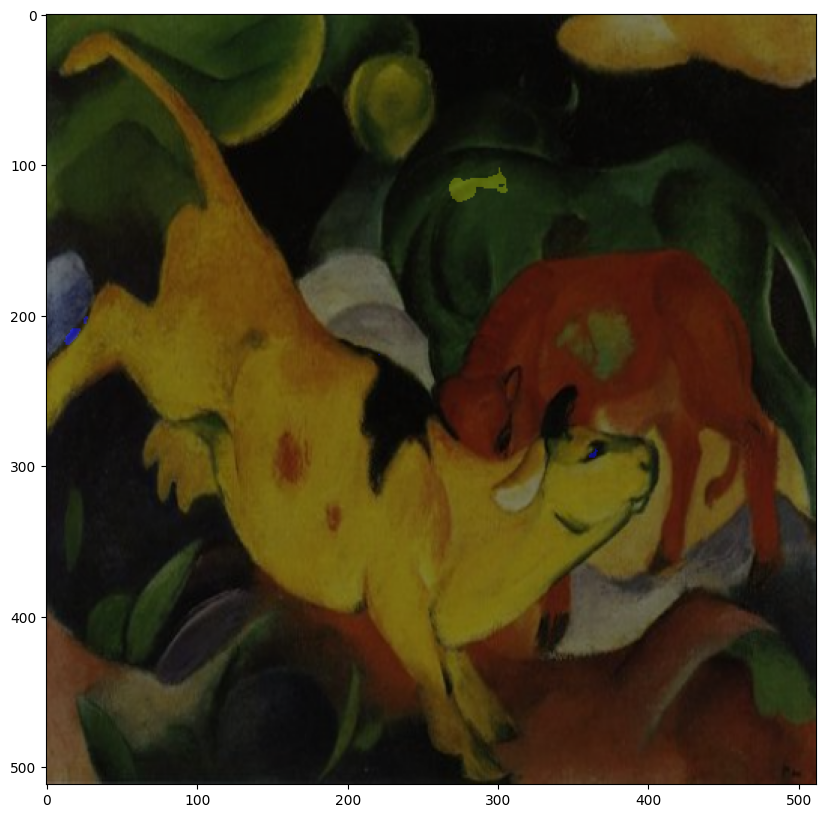

(512, 512, 3)
(512, 512, 3)
[  0 255]


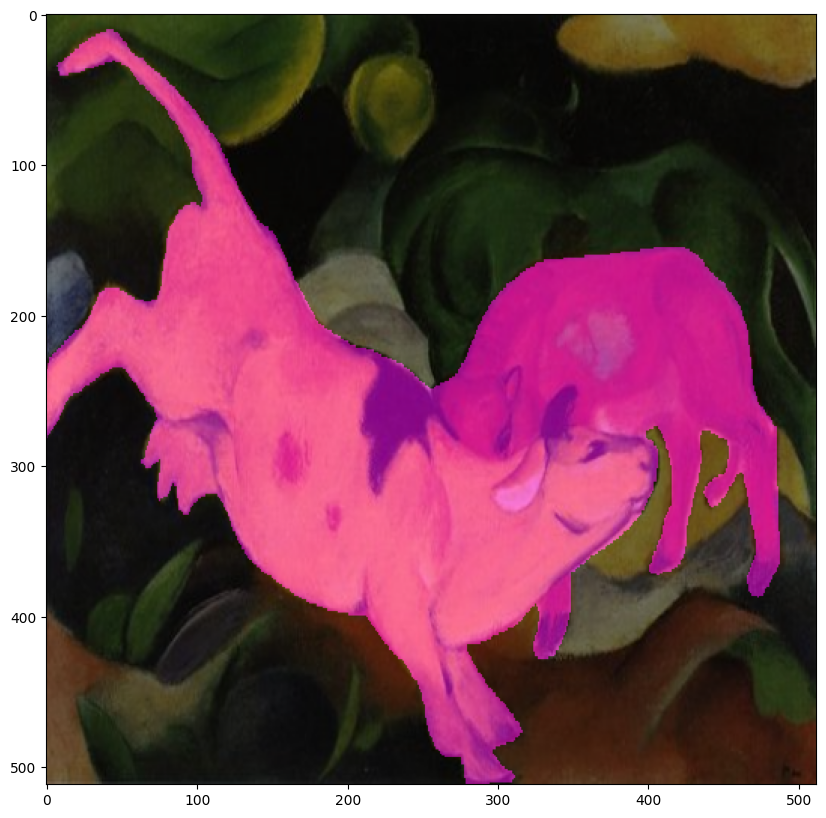

Predicted labels
background
bird
pottedplant
Ground truth labels
background
cow


In [28]:
vizualization_batch_index = 16
vizualization_index = 12

vizualization_pred_label = pred_labels_list[vizualization_batch_index][vizualization_index]
image = test_dataset1[vizualization_batch_index*32 + vizualization_index][2]
gt_label = test_dataset1[vizualization_batch_index*32 + vizualization_index][1]

vizualize_label(vizualization_pred_label, image) 
vizualize_label(gt_label, image) 

print('Predicted labels')
labels = np.unique(vizualization_pred_label)
for i in labels:
    print(id2label[i])
    
print('Ground truth labels')
labels = np.unique(gt_label)
for i in labels:
    print(id2label[i])